# Introduction to Deep Learning with Keras and TensorFlow

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building a toy model for classifying handwritten numbers with accuracies surpassing 95%. This model will be a convolutional neural network.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

![MNIST](https://www.researchgate.net/profile/Kofi_Appiah/publication/252028600/figure/fig2/AS:298067136925718@1448076151592/Some-samples-of-the-MNIST-database.png)

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [1]:
try:
    import tensorflow as tf
    if tf.__version__.startswith('2.4'):
        pass
    else:
        !pip3 install tensorflow-gpu==2.4.0
except:
    !pip3 install tensorflow-gpu==2.4.0
    
import tensorflow as tf
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow.keras as keras

from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, \
    ZeroPadding2D, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Introducing Convolution! What is it?
Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.
![conf](https://miro.medium.com/max/500/1*GcI7G-JLAQiEoCON7xFbhg.gif)
In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.
![filters](https://miro.medium.com/max/684/1*wFVu-TnKupy86DgZwvMcdw.png)
Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called max pooling, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).
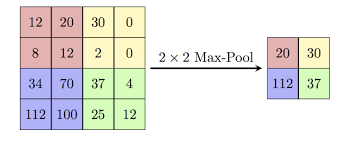
We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*
![meme](https://miro.medium.com/max/5668/1*pPPFfrlPQsXeG3eZA0-v2A.png)


## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [2]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


## Formatting the input data layer

Now we do want to use a `28` by `28` image! But we need to add an extra dimension, representing the channel!

In [3]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

Format `Y_train` and `Y_test` to a one hot encoding. Try using the `tensorflow.keras.utils.to_categorical` method for this!

In [4]:
nb_classes = 10 # number of unique digits

Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

# Building the model
Build a model with 4 convolutional layers, and two Dense layers. Use the following specifications:
* All convolutional layers should have a filter size of `(3, 3)`
* Use batch normalization after each convolutional layer
* Use ReLU activation functions
* Use a MaxPool operation on the 2nd, 3rd adn 4th convolution layer, after the ReLU
* Afther the 4th convolutional layer, flatten the output using `Flatten()`
* Add two Dense layers with 512 and 10 outputs, respectively. 

In [5]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))

In [6]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0

## Compiling the model

In [7]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [8]:
# Call the model.fit() function here. We recommend setting verbose=1
model.fit(X_train, Y_train,
          batch_size=128, epochs=1,
          verbose=1)

469/469 [==============================] - 50s 104ms/step - loss: 0.1977 - accuracy: 0.9373


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [9]:
# Call model.evaluate()
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.2057 - accuracy: 0.9387
Test score: 0.20573635399341583
Test accuracy: 0.9387000203132629


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# choose any image to want by specifying the index
img = X_test[3]
img = np.expand_dims(img, axis=0) # Keras requires the image to be in 4D, so we add an extra dimension to it.

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
        
    _convout1_f = Model(model.inputs, layer.output)
    
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[-1]
    n = int(np.ceil(np.sqrt(m)))
        
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')

Shape of conv: (26, 26, 32)


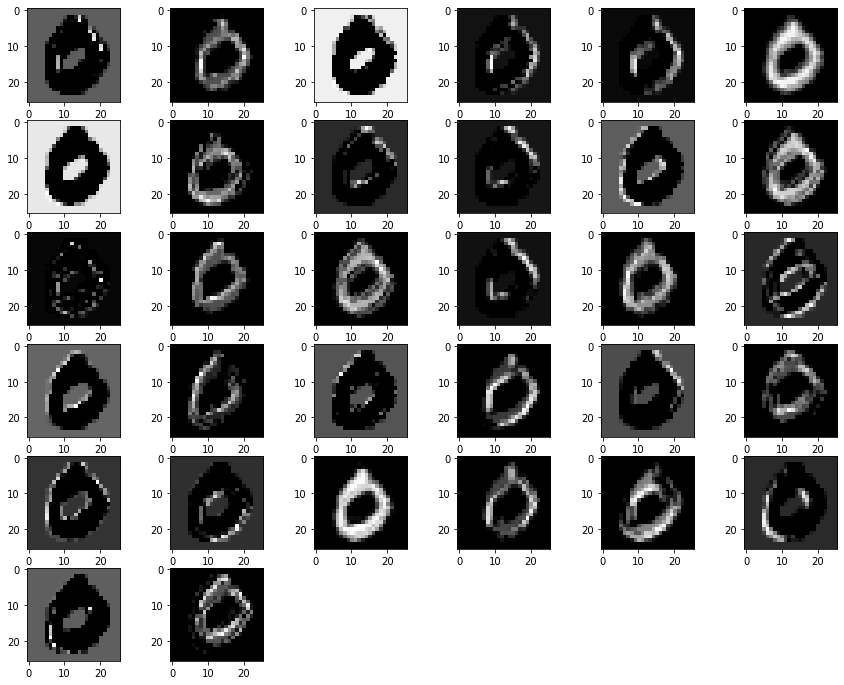

In [25]:
visualize(convLayer01) # visualize first set of feature maps

Shape of conv: (12, 12, 32)


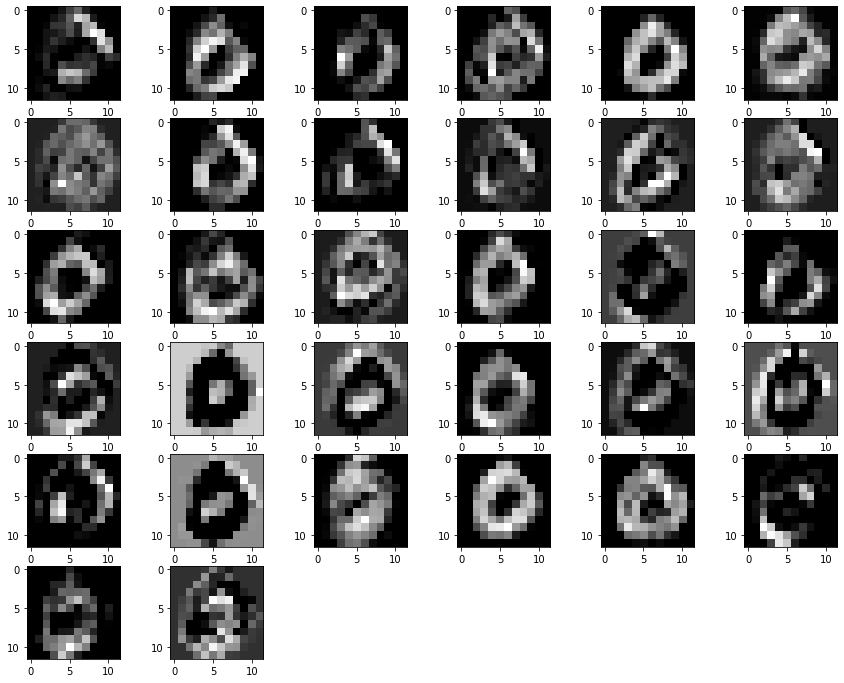

In [26]:
visualize(convLayer02) # visualize second set of feature maps

Shape of conv: (10, 10, 64)


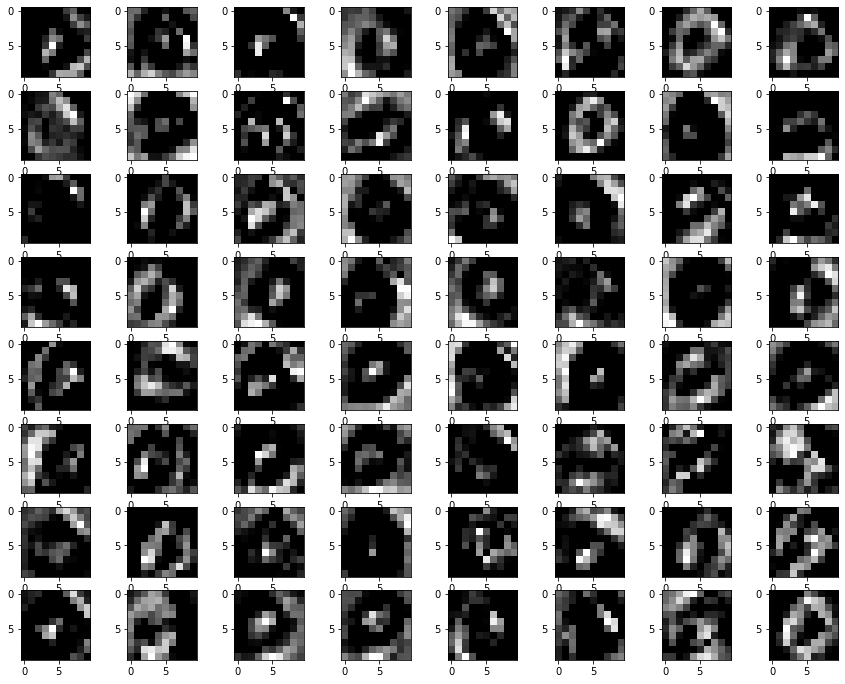

In [27]:
visualize(convLayer03)# visualize third set of feature maps

Shape of conv: (4, 4, 64)


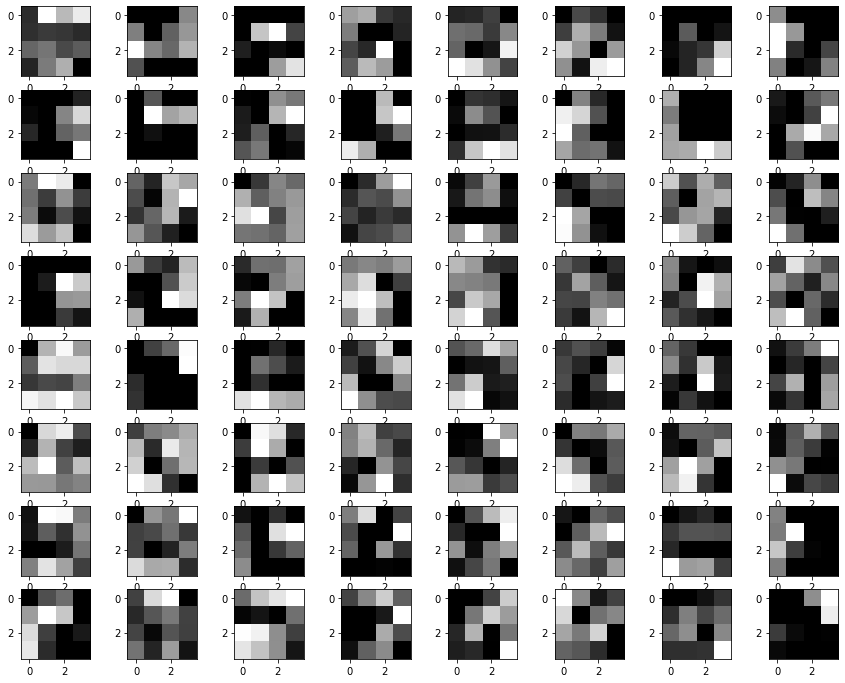

In [28]:
visualize(convLayer04)# visualize fourth set of feature maps